In [1]:
import matplotlib.pyplot as plt
import numpy as np
from landlab import RasterModelGrid
from bmi_topography import Topography
from landlab.io import read_esri_ascii
from landlab import RasterModelGrid, imshow_grid, imshowhs_grid
from landlab.plot.graph import plot_graph # to plot things and check they are happening correctly
from landlab.components import PriorityFloodFlowRouter # getting things to make run the flood flow
from landlab.components import FlowAccumulator, LateralEroder # for the lateral erosion of the channel

## Lateral Channel Migration

### Downloading the DEM

In [2]:
# Create an instance of Topography using parameters to describe

# 1. the type of data requested,
# 2. the geographic bounding box of the data,
# 3. the file format (we want to save it as an ascii file), and
# 4. where to store the file

topo = Topography(
    dem_type="SRTMGL1",
    south=39.93,
    north=40.0,
    west=-105.33,
    east=-105.26,
    output_format="AAIGrid",
    cache_dir="DEMData//",
)

/opt/tljh/user/envs/ivy/lib/python3.13/site-packages/bmi_topography/api_key.py:48: UserWarning: You are using a demo key to fetch data from OpenTopography, functionality will be limited. See https://bmi-topography.csdms.io/en/latest/#api-key for more information.
  warnings.warn(


In [3]:
# fetching the data now
fname = topo.fetch()
print(fname)

/home/jupyter-mcarrington@utexas-7503b/ESPIn_Floods_2025-morggy-poo/notebooks/mcarr/DEMData/SRTMGL1_39.93_-105.33_40.0_-105.26.asc


In [4]:
# now committing the data to memory
dem = topo.load()
print(dem)

<xarray.DataArray 'SRTMGL1' (band: 1, y: 252, x: 252)> Size: 254kB
[63504 values with dtype=int32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 2kB -105.3 -105.3 -105.3 ... -105.3 -105.3 -105.3
  * y            (y) float64 2kB 40.0 40.0 40.0 40.0 ... 39.93 39.93 39.93 39.93
    spatial_ref  int64 8B 0
Attributes:
    _FillValue:    -32768
    scale_factor:  1.0
    add_offset:    0.0
    units:         unknown


/opt/tljh/user/envs/ivy/lib/python3.13/site-packages/bmi_topography/topography.py:216: UserWarning: A CRS cannot be identified for these data. Grid units will be set to 'unknown'.
  warnings.warn(


/tmp/ipykernel_755233/1787709006.py:2: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation")


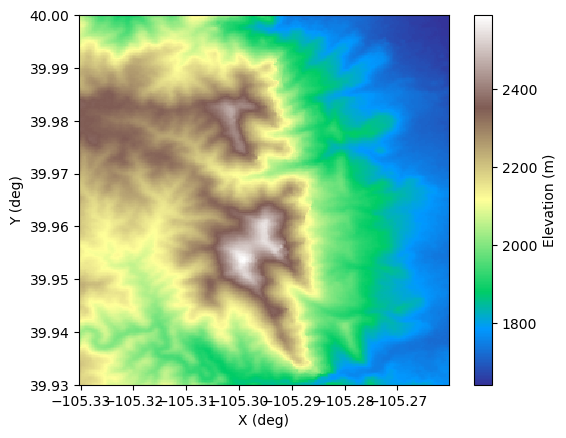

In [5]:
# Read DEM as Landlab grid
grid_geog, elev = read_esri_ascii(fname, name="topographic__elevation")

grid_geog.imshow(
    "topographic__elevation",
    cmap="terrain",
    grid_units=("deg", "deg"),
    colorbar_label="Elevation (m)",
)

<Axes: xlabel='Easting', ylabel='Northing'>

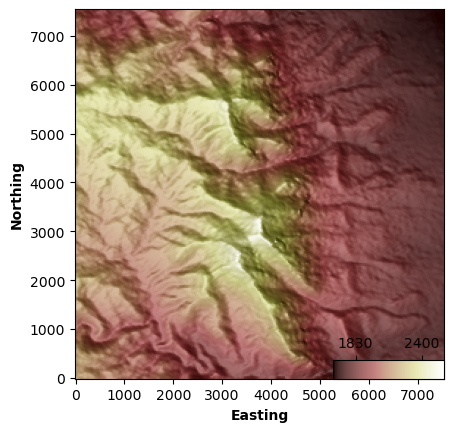

In [6]:
# make a new grid with RasterModelGrid, use the dimensions of grid_geog
grid = RasterModelGrid(grid_geog.shape, xy_spacing=30.0)
grid.at_node["topographic__elevation"] = grid_geog.at_node["topographic__elevation"]

imshowhs_grid(grid, "topographic__elevation")

In [7]:
# These are plotting functions

def plotting(
    grid, topo=True, DA=True, hill_DA=False, flow_metric="D8", hill_flow_metric="Quinn"
):
    if topo:
        azdeg = 200
        altdeg = 20
        ve = 1
        plt.figure()
        plot_type = "DEM"
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            var_name="Topo, m",
            cmap="terrain",
            plot_type=plot_type,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            default_fontsize=12,
            cbar_tick_size=10,
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )
    if DA:
        # %% Plot first instance of drainage_area
        grid.at_node["drainage_area"][grid.at_node["drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        plot_DA = np.log10(grid.at_node["drainage_area"] * 111e3 * 111e3)

        plt.figure()
        plot_type = "Drape1"
        drape1 = plot_DA
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=12,
            cbar_tick_size=10,
            var_name="$log^{10}DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=+5,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

    if hill_DA:
        # Plot second instance of drainage_area (hill_drainage_area)
        grid.at_node["hill_drainage_area"][grid.at_node["hill_drainage_area"] == 0] = (
            grid.dx * grid.dx
        )
        # plotDA = np.log10(grid.at_node["hill_drainage_area"] * 111e3 * 111e3)
        # plt.figure()
        # imshow_grid(grid, plotDA,grid_units=("m", "m"), var_name="Elevation (m)", cmap='terrain')

        plt.figure()
        plot_type = "Drape1"
        # plot_type='Drape2'
        drape1 = np.log10(grid.at_node["hill_drainage_area"])
        thres_drape1 = None
        alpha = 0.5
        ax = imshowhs_grid(
            grid,
            "topographic__elevation",
            grid_units=("deg", "deg"),
            cmap="terrain",
            plot_type=plot_type,
            drape1=drape1,
            vertical_exa=ve,
            azdeg=azdeg,
            altdeg=altdeg,
            thres_drape1=thres_drape1,
            alpha=alpha,
            default_fontsize=10,
            cbar_tick_size=10,
            var_name="$log^{10} DA, m^2$",
            cbar_width="100%",
            cbar_or="vertical",
            bbox_to_anchor=[1.03, 0.3, 0.075, 14],
            colorbar_label_y=-15,
            colorbar_label_x=0.5,
            ticks_km=False,
        )

        props = dict(boxstyle="round", facecolor="white", alpha=0.6)
        textstr = hill_flow_metric
        ax.text(
            0.05,
            0.95,
            textstr,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=props,
        )

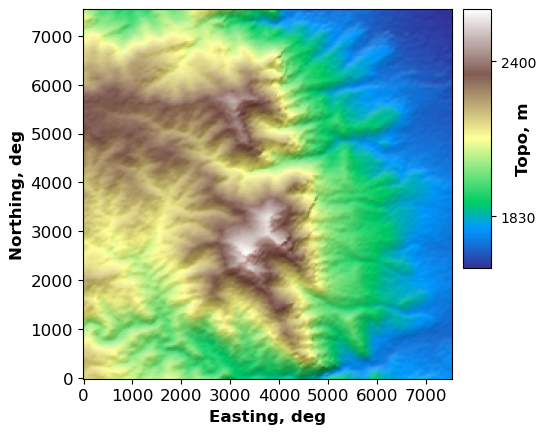

In [8]:
# Plot output products
plotting(grid, DA=False)

### Initializing PriorityFlowFloodRouter

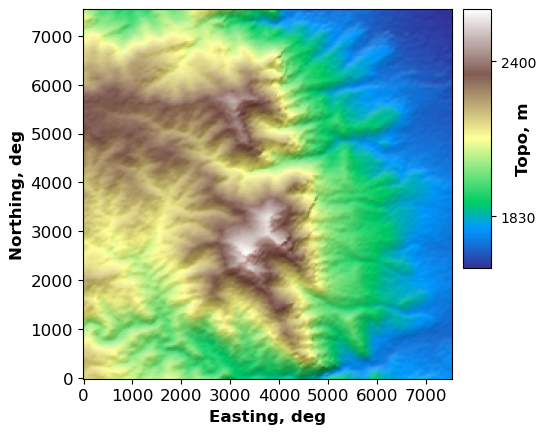

In [9]:
flow_metric = 'D8'
flow_acc_PF = PriorityFloodFlowRouter(grid, surface = 'topographic__elevation', flow_metric = flow_metric,
                                suppress_out = True, depression_handler = 'fill', accumulate_flow = True,
                                separate_hill_flow = True, accumulate_flow_hill = True)

U = 0.001
dt = 100

flow_acc_PF.run_one_step()

# Plot output products
plotting(grid, DA=False)

### Initializing Lateral Erosion

In [10]:
grid.add_zeros('volume__lateral_erosion', at = 'node')
lateral = LateralEroder(grid, latero_mech = 'UC', Kv = 0.001, Kl_ratio = 1.5)
grid, dzlat = lateral.run_one_step(dt)

In [12]:
# for i in range(0,10):
#     flow_acc_PF.run_one_step()
#     grid, dzlat = lateral.run_one_step(dt)

while min(dzlat) == 0.0:
    oldlatvol = grid.at_node["volume__lateral_erosion"].copy()
    oldelev = grid.at_node["topographic__elevation"].copy()
    fa.run_one_step()
    grid, dzlat = lateral.run_one_step(dt)
    newlatvol = grid.at_node["volume__lateral_erosion"]
    newelev = grid.at_node["topographic__elevation"]
    grid.at_node["topographic__elevation"][grid.core_nodes] += U * dt

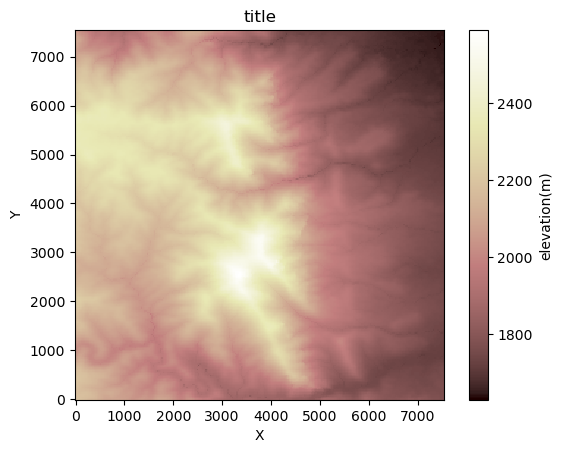

In [13]:
grid.imshow("topographic__elevation", plot_name="title", var_name="elevation(m)")

In [14]:
print(dzlat)

[0. 0. 0. ... 0. 0. 0.]
